/tmp/ipykernel_20/674520431.py:101: RuntimeWarning: divide by zero encountered in divide
  cosmic_ray = cosmic_ray_amplitude / ((self.wavelengths - self.wavelengths[position]) ** 2)
/tmp/ipykernel_20/674520431.py:104: RuntimeWarning: invalid value encountered in divide
  cosmic_ray = cosmic_ray / cosmic_ray.max()


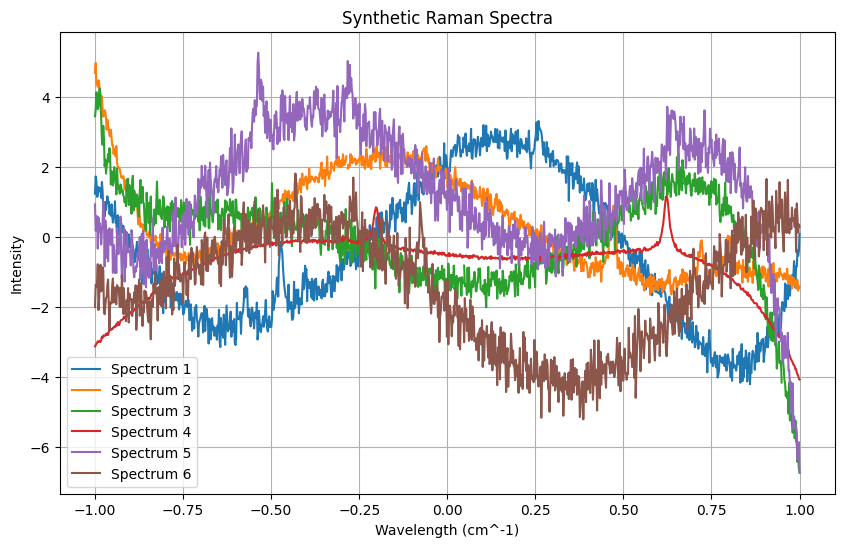

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. INPUT PARAMETERS
class SyntheticRamanSpectrum:
    def __init__(self, pixels, poly_order_range, num_peaks_range, snr_range, cosmic_ray_prob, num_spectra):
        self.pixels = pixels
        self.poly_order_range = poly_order_range
        self.num_peaks_range = num_peaks_range
        self.snr_range = snr_range
        self.cosmic_ray_prob = cosmic_ray_prob
        self.num_spectra = num_spectra
        self.wavelengths = np.linspace(-1, 1, self.pixels)
        self.full_spectra_list = [] 

    # 2. CHEBYSHEV BASELINE    
    def chebyshev_polynomial(self, x, *coefficients):
        order = len(coefficients)
        chebyshev_vals = np.zeros_like(x)
    
        for i in range(order):
            chebyshev_vals += coefficients[i] * np.cos(i * np.arccos(np.array(x)))
        
        return chebyshev_vals
    
    def generate_spectrum(self):
        # Randomly select polynomial order for Chebyshev baseline
        poly_order = np.random.randint(self.poly_order_range[-1], self.poly_order_range[1] + 1)

        # Initialize an empty array to store Chebyshev coefficients
        cheby_baseline_coefficients = np.random.uniform(-1, 1, poly_order + 1)

        # Generate Chebyshev coefficients iteratively
        for i in range(poly_order + 1):
            cheby_baseline_coefficients[i] = np.random.uniform(-1, 1)

        # Generate Chebyshev baseline
        self.cheby_baseline = self.chebyshev_polynomial(self.wavelengths, *cheby_baseline_coefficients)
    
    # 3. LORENTZIAN PEAKS
    def add_lorentzian_peaks(self):
        # Define parameters for Lorentzian peaks
        num_peaks = np.random.randint(self.num_peaks_range[0], self.num_peaks_range[1] + 1)
        peak_amplitudes = np.random.uniform(0, 1, num_peaks)
        peak_positions = np.random.uniform(-1, 1, num_peaks)
        peak_width = 1 / (self.pixels * 0.1)

        # Initialize peaks array
        peaks = np.zeros_like(self.wavelengths)

        # Add Lorentzian peaks to spectrum
        for i in range(num_peaks):
            peaks += peak_amplitudes[i] * (peak_width ** 2) / ((self.wavelengths - peak_positions[i]) ** 2 + peak_width ** 2)

        # Update peaks attribute
        self.peaks = peaks

        # Add peaks to Chebyshev baseline
        self.peaky_cheby = self.peaks + self.cheby_baseline
    
    # 4. NOISE GENERATION
    def add_gaussian_noise(self, noise_amplitude_range=(0, 1)):
        # Calculate signal power
        signal_power = np.mean(np.abs(self.cheby_baseline + self.peaks) ** 2)

        # Calculate noise power based on SNR
        noise_power = signal_power / self.snr_range

        # Calculate standard deviation of noise
        noise_std = np.sqrt(noise_power)

        # Generate random noise amplitudes within specified range
        min_amp, max_amp = noise_amplitude_range
        noise_amplitudes = np.random.uniform(min_amp, max_amp)

        # Generate Gaussian noise samples
        noise = np.random.normal(0, noise_std, len(self.wavelengths))

        # Scale noise by noise amplitudes
        total_noise = noise * noise_amplitudes
        
        # Add noise to peaky cheby spectra
        self.noisy_peaky_cheby = self.peaky_cheby + total_noise

    # 5. COSMIC RAYS
    def add_cosmic_rays(self, num_cosmic_rays):
        cosmic_rays_spectrum = self.noisy_peaky_cheby.copy()
    
        # Calculate L2-norm of complete signal
        l2_norm = np.linalg.norm(cosmic_rays_spectrum)
    
        for _ in range(num_cosmic_rays):
            # Generate random amplitude randomized between 0.8 & L2-norm of complete signal
            cosmic_ray_amplitude = np.random.uniform(0.8, l2_norm)
        
            # Randomly select position for cosmic ray, width = 0
            position = np.random.randint(0, len(cosmic_rays_spectrum))
        
            # Create cosmic ray using y = 1 / (x - position)^2
            cosmic_ray = cosmic_ray_amplitude / ((self.wavelengths - self.wavelengths[position]) ** 2)

            # Normalize cosmic ray
            cosmic_ray = cosmic_ray / cosmic_ray.max()

            # Add cosmic ray to spectrum
            cosmic_rays_spectrum += cosmic_ray

        # Update full synthetic spectrum with cosmic rays
        full_spectrum = cosmic_rays_spectrum + self.noisy_peaky_cheby
        self.full_spectra_list.append(full_spectrum)

# Parameters
pixels = 1024
poly_order_range = (2, 5)
num_peaks_range = (3, 6)
snr_range = 20
cosmic_ray_prob = 0.1
num_spectra = 6

synthetic_data_generator = SyntheticRamanSpectrum(pixels, poly_order_range, num_peaks_range, snr_range, cosmic_ray_prob, num_spectra)

# Generate synthetic spectra
for _ in range(num_spectra):
    # Randomly sample parameter values within specified ranges
    synthetic_data_generator.generate_spectrum()
    synthetic_data_generator.add_lorentzian_peaks()
    synthetic_data_generator.add_gaussian_noise()
    
    # Random number of cosmic rays between 0 & 5
    num_cosmic_rays = np.random.randint(0, 6)
    synthetic_data_generator.add_cosmic_rays(num_cosmic_rays)

# Generate spectra
full_spectra = np.array(synthetic_data_generator.full_spectra_list)

# Reshape data for 2 columns (x & y)
num_spectra, num_pixels = full_spectra.shape
x = np.linspace(-1, 1, num_pixels)

# Reshape data
reshaped_data = full_spectra.reshape(num_spectra * num_pixels, 1)

# Create a DataFrame
df = pd.DataFrame({'Wavelength': np.tile(x, num_spectra), 'Intensity': reshaped_data.flatten()})

# Save DataFrame
df.to_csv('synthetic_spectra_xy.csv', index=False)

# Reshape data for 2 columns (x & y)
num_spectra, num_pixels = full_spectra.shape
x = np.linspace(-1, 1, num_pixels)

# Create a figure for plotting spectra
plt.figure(figsize=(10, 6))

for i in range(num_spectra):
    spectrum = full_spectra[i]

    # Plot spectra
    plt.plot(x, spectrum, label=f'Spectrum {i + 1}')

# Customize plot
plt.xlabel('Wavelength (cm^-1)')
plt.ylabel('Intensity')
plt.title('Synthetic Raman Spectra')
plt.legend()
plt.grid()

# Show plot
plt.show()